In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from numpy.testing import assert_array_equal
from tqdm.notebook import tqdm

In [2]:
from microagg1d.main import _simple_dynamic_program,_simple_dynamic_program2,  compute_cluster_cost_sorted
from microagg1d.wilber import wilber, _galil_park
from microagg1d.wilber2 import wilber2, _galil_park2

In [3]:
from functools import partial

In [24]:
def execute(ns, n_samples, methods, ks=[2, 5, 10, 20, 30, 50, 75, 100, 200, 500, 1000] ):
    
    # ensure that functions are already compiled!
    small_arr = np.random.rand(10)
    small_arr.sort()
    for method_str, function in methods.items():
        function(small_arr, 3)
    
    records = []
    for n in tqdm(ns, leave=False):
        for sample in tqdm(range(n_samples), leave=False):
            np.random.seed(sample)
            start = time.time()
            arr = np.random.rand(n)
            end = time.time()
            records.append(("sample", n, 0, sample, end - start))

            start = time.time()
            arr.sort()
            end = time.time()
            records.append(("sorting", n, 0, sample, end - start))
            for k in tqdm(ks, leave=False):
                if k > n/2:
                    continue
                for method_str, function in methods.items():
                    start = time.time()
                    result1 = function(arr, k)
                    end = time.time()
                    records.append((method_str, n, k, sample, end - start))
    return records

In [5]:
%%time
ns = [100, 1000, 10_000, 100_000]

n_samples = 10
methods = {
    "wilber" : partial(wilber, stable=0),
    "wilber2" : partial(wilber2, stable=0),
#    "simple" : partial(_simple_dynamic_program, stable=0),
    "simple2" : partial(_simple_dynamic_program2, stable=0),
    "galil_park": partial(_galil_park, stable=0),
    "galil_park2": partial(_galil_park2, stable=0),
    "wilber_stable" : partial(wilber, stable=1),
    "wilber2_stable" : partial(wilber2, stable=1),
#    "simple_stable" : partial(_simple_dynamic_program, stable=1),
    "simple2_stable" : partial(_simple_dynamic_program2, stable=1),
    "galil_park_stable": partial(_galil_park, stable=1),
}
records = execute(ns, n_samples, methods)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 1min
Wall time: 1min


In [6]:
df = pd.DataFrame.from_records(records, columns=["name", "n", "k", "sample", "time"])

In [7]:
def get_vals(df, name, n, max_k=None):
    df2 = df[df["name"]==name]
    if not max_k is None:
        df2=df2[df2["k"] < max_k ]
    df2 = df2[df2["n"]==n]
    df2 = df2.drop(["name", "n", "sample"], axis=1)
    df2 = df2.groupby("k").aggregate((np.mean, np.std))
    return df2.index, df2.time["mean"], df2.time["std"], 

In [8]:
get_vals(df, "sorting", 100_000)[1][0]

0.005603289604187012

In [9]:
color_wilber="orange"
color_wilber2="red"
color_galil="green"
color_galil2="lime"
color_simple="blue"
color_simple2="teal"

In [16]:
def plot(df, n, max_k = None, show_simple=False):
    plt.figure()
    plt.errorbar(*get_vals(df, "wilber", n, max_k), label="wilber", color=color_wilber)
    plt.errorbar(*get_vals(df, "wilber_stable", n, max_k), label="wilber_stable", linestyle="--", color=color_wilber)
    
    plt.errorbar(*get_vals(df, "wilber2", n, max_k), label="wilber2", color=color_wilber2)
    plt.errorbar(*get_vals(df, "wilber2_stable", n, max_k), label="wilber2_stable", linestyle="--", color=color_wilber2)
    if show_simple:
        #plt.errorbar(*get_vals(df, "simple", n, max_k), label="simple", color=color_simple)
        #plt.errorbar(*get_vals(df, "simple_stable", n, max_k), label="simple_stable", linestyle="--", color=color_simple)
        
        plt.errorbar(*get_vals(df, "simple2", n, max_k), label="simple2", color=color_simple2)
        plt.errorbar(*get_vals(df, "simple2_stable", n, max_k), label="simple_stable2", linestyle="--", color=color_simple2)

    plt.errorbar(*get_vals(df, "galil_park", n, max_k), label="galil", color=color_galil)
    plt.errorbar(*get_vals(df, "galil_park2", n, max_k), label="galil2", color=color_galil2)
    plt.errorbar(*get_vals(df, "galil_park_stable", n, max_k), label="galil_stable", linestyle="--", color=color_galil)
    plt.axhline(get_vals(df, "sorting", n)[1][0], color="k", label="sorting")
    #plt.axhline(get_vals(df, "sorting", 100_000)[1][0], color="k", label="sorting")
    plt.ylabel("runtime [s]")
    plt.xlabel("k")
    plt.title(f"runtime for n={n:,}")
    plt.legend()
    #plt.xscale("log")

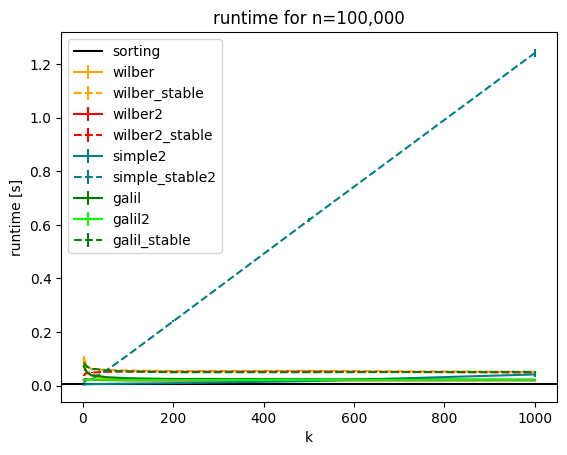

In [17]:
plot(df, 100_000, show_simple=True)

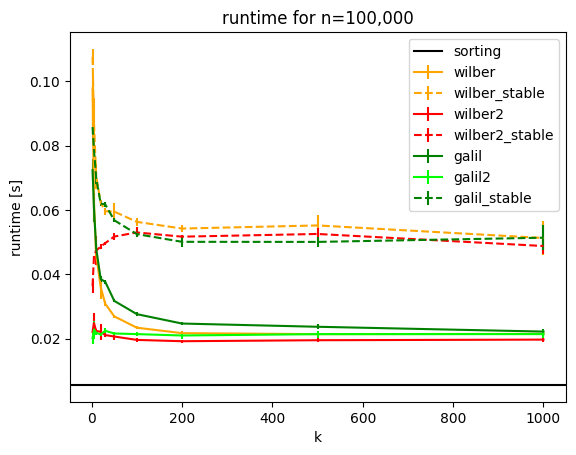

In [18]:
plot(df, 100_000, show_simple=False)

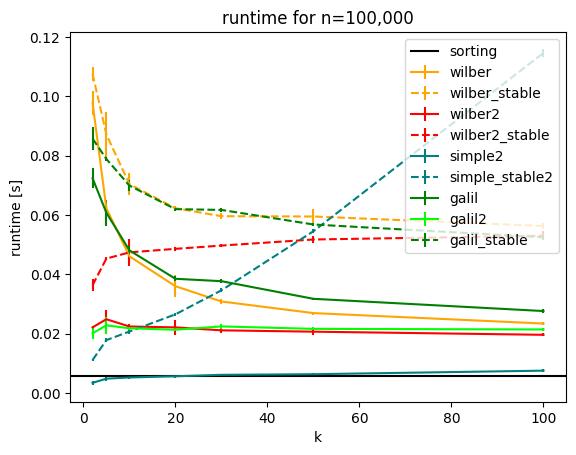

In [19]:
plot(df, 100_000, max_k=110, show_simple=True)

In [25]:
%%time
large_methods = {
    "wilber" : partial(wilber, stable=0),
    "galil_park": partial(_galil_park, stable=0),
    "simple2" : partial(_simple_dynamic_program2, stable=0),
#    "wilber_stable" : partial(wilber, stable=1),
#    "galil_park_stable": partial(_galil_park, stable=0),
}
records_large = execute([1_000_000], 10, large_methods, ks = [10,100,200,400,800, 1600, 2000, 3000, 4000, 5000])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 1min 26s
Wall time: 1min 26s


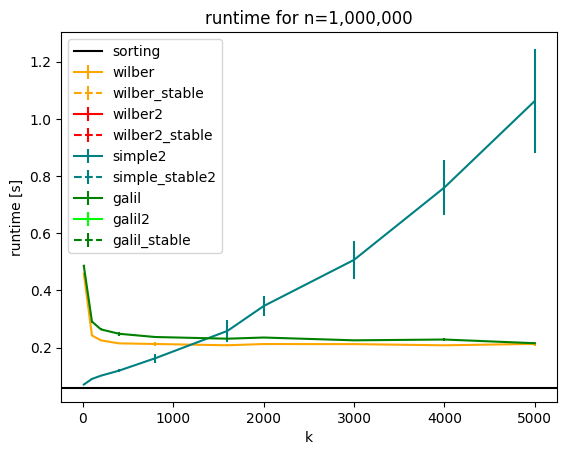

In [26]:
df_large = pd.DataFrame.from_records(records_large, columns=["name", "n", "k", "sample", "time"])
plot(df_large, 1_000_000, show_simple=True)